In [1]:
from util import read_config

model_cfg = read_config('config/model.yaml')
model_cfg

{'model': {'name': 'point_gnn',
  'module_default': {'point_feat_dim': 128,
   'edge_feat_dim': 128,
   'default_activation': 'leaky_relu',
   'point_gnn_default': {'mlp_h': {'inp_dim': 128,
     'hidden_dim_lst': [64, 16],
     'out_dim': 3,
     'activation': 'leaky_relu',
     'output_activation': 'none',
     'add_batch_norm': False},
    'mlp_f': {'inp_dim': 128,
     'hidden_dim_lst': [128, 128],
     'out_dim': 128,
     'activation': 'leaky_relu',
     'output_activation': 'none',
     'add_batch_norm': False},
    'mlp_g': {'inp_dim': 128,
     'hidden_dim_lst': [128, 128],
     'out_dim': 128,
     'activation': 'leaky_relu',
     'output_activation': 'none',
     'add_batch_norm': False}}},
  'modules': [{'name': 'entry', 'inp_src': ['args:0', 'args:1', 'args:2']},
   {'name': 'point_net_encoder',
    'cls': 'point_net_encoder',
    'inp_src': ['args:0', 'args:1', 'args:2'],
    'config': {'out_varname': 'x',
     'local_nn': {'inp_dim': 1,
      'hidden_dim_lst': [4, 16, 64

In [2]:
from model import ComposableModel
model = ComposableModel(model_name=model_cfg.model.name, config=model_cfg.model.modules)
model = model.to("cuda")

In [3]:
model

ComposableModel(
  (point_net_encoder): PointNetEncoder(
    (local_nn): Mlp(
      (mlp): Sequential(
        (0): Linear(in_features=4, out_features=4, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
        (2): Linear(in_features=4, out_features=16, bias=True)
        (3): LeakyReLU(negative_slope=0.01)
        (4): Linear(in_features=16, out_features=64, bias=True)
        (5): LeakyReLU(negative_slope=0.01)
        (6): Linear(in_features=64, out_features=128, bias=True)
      )
    )
    (global_nn): Mlp(
      (mlp): Sequential(
        (0): Linear(in_features=128, out_features=128, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
        (2): Linear(in_features=128, out_features=128, bias=True)
        (3): LeakyReLU(negative_slope=0.01)
        (4): Linear(in_features=128, out_features=128, bias=True)
      )
    )
    (conv): PointNetConv(local_nn=Mlp(
      (mlp): Sequential(
        (0): Linear(in_features=4, out_features=4, bias=True)
        (1): LeakyReLU(n

In [19]:
import torch
chkpt = torch.load("runs/2025-02-11_18-13-26/chkpt/best_model.pt",
                   weights_only=False)

In [20]:
corrected_chkpt = {k.replace('_orig_mod.', ''): v for k, v in chkpt["model"].items()}

In [21]:
m, u = model.load_state_dict(corrected_chkpt, strict=True,)

In [22]:
m

[]

In [23]:
u

[]

In [5]:
from dataset import DatasetRegistry
data_cfg = read_config('config/dataset_wsl.yaml')
ds_train = DatasetRegistry.build(
        mode="train",
        name=data_cfg.name,
        config=data_cfg.config,
    )
data = ds_train[0]
data = data.to("cuda")

/home/liuji/GitHub/PointGNN/dataset/dataset.py:233: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(


In [6]:
out_encoder = model.point_net_encoder(data.x, data.pos, data.edge_index)

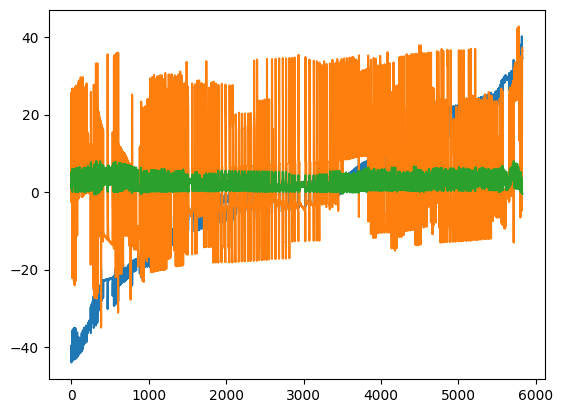

In [ ]:
import matplotlib.pyplot as plt
plt.plot(data.pos.cpu().numpy())

In [33]:
from copy import deepcopy
data_z = deepcopy(data)
def zscore(x: torch.Tensor, axis: int = 0) -> torch.Tensor:
    """
    Computes the Z-score normalization of a tensor along a specified axis.

    Args:
        x (torch.Tensor): The input tensor.
        axis (int): The axis along which to compute the Z-score. Default is 0.

    Returns:
        torch.Tensor: The Z-score normalized tensor.
    """
    mean = torch.mean(x, dim=axis, keepdim=True)
    std = torch.std(x, dim=axis, keepdim=True)
    return (x - mean) / (std + 1e-8) # Adding a small epsilon to avoid division by zero

data_z.pos = zscore(data_z.pos, axis=0)


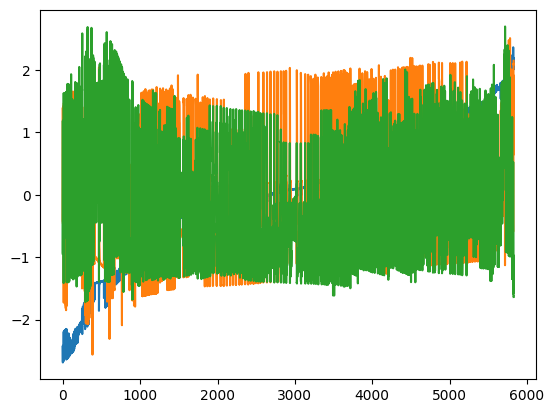

In [34]:
d = data_z.pos.cpu().numpy()
plt.plot(d)

In [35]:
out_encoder_z = model.point_net_encoder(data_z.x, data_z.pos, data_z.edge_index)

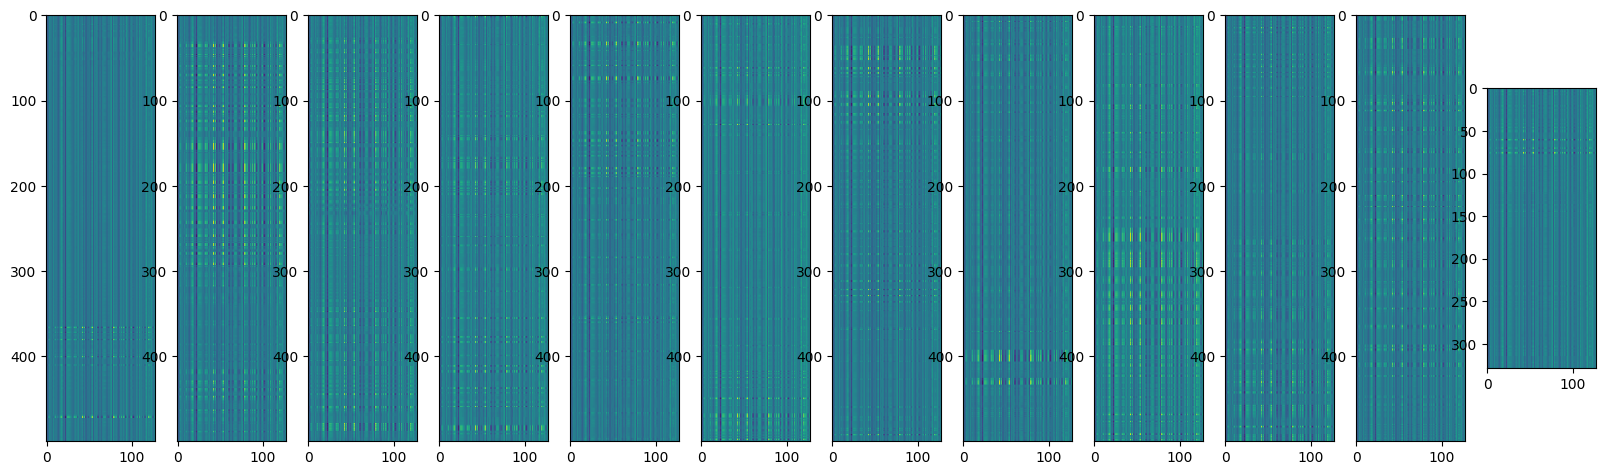

In [37]:
n = 500
d = out_encoder_z["point_net_encoder:x"].detach().cpu().numpy()
m = d.shape[0]
col = np.ceil(m/n).astype(int)
plt.figure(figsize=(20, 20))
for i in range(col):
    plt.subplot(1, col, i+1)
    plt.imshow(d[i*n:np.minimum((i+1)*n, m)])

plt.show()

In [29]:
data.edge_index.shape

torch.Size([2, 34974])

<Figure size 1000x1000 with 0 Axes>

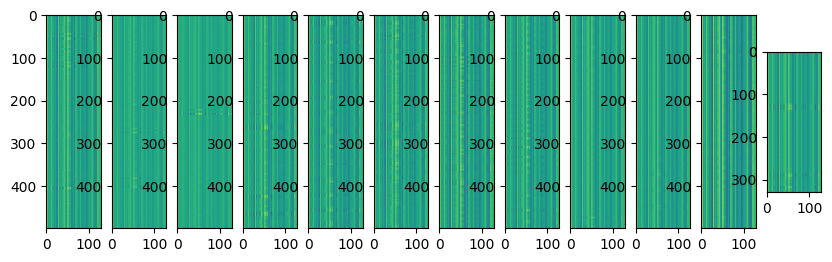

In [22]:
import numpy as np
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))

n = 500
d = out_encoder["point_net_encoder:x"].detach().cpu().numpy()
m = d.shape[0]
col = np.ceil(m/n).astype(int)
plt.figure(figsize=(10, 10))
for i in range(col):
    plt.subplot(1, col, i+1)
    plt.imshow(d[i*n:np.minimum((i+1)*n, m)])

plt.show()

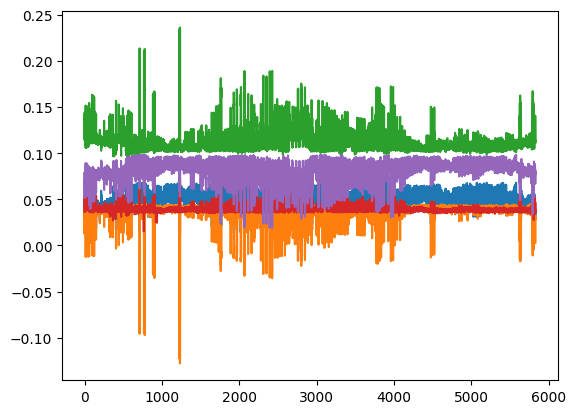

In [31]:
plt.plot(d[:,:5])

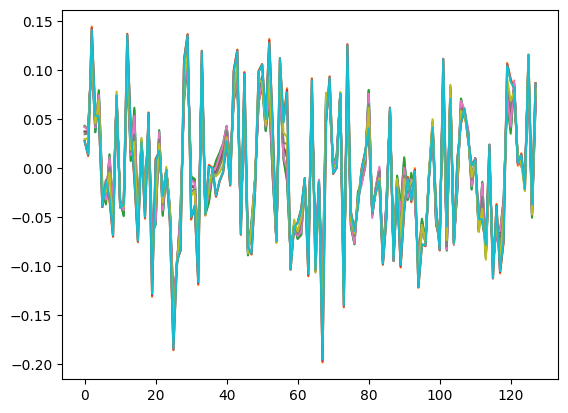

In [30]:
plt.plot(d[:10, :].T)

In [9]:
out_encoder["point_net_encoder:x"].shape

torch.Size([5829, 128])

In [25]:
model.eval()
out = model(data.x, data.pos, data.edge_index)

In [26]:
out.keys()

dict_keys(['background', 'object', 'localization', 'box_size', 'orientation'])

In [27]:
out["localization"][data.mask][:10]

tensor([[-0.0045,  0.0063,  0.0305],
        [-0.0098,  0.0069,  0.0608],
        [-0.0201,  0.0043,  0.0273],
        [-0.1097,  0.0198, -0.0697],
        [-0.0982,  0.0084, -0.1130],
        [-0.0288,  0.0036, -0.0090],
        [ 0.0115,  0.0049,  0.0021],
        [-0.0003,  0.0025, -0.0111],
        [-0.1005,  0.0104, -0.1095],
        [-0.1337,  0.0093, -0.1404]], device='cuda:0',
       grad_fn=<SliceBackward0>)

In [28]:
data.target["localization"][data.mask][:10]

tensor([[ 0.8638, -0.2757,  0.2373],
        [ 0.8683, -0.2642,  0.1658],
        [ 0.8758, -0.2451,  0.0214],
        [ 0.8697, -0.1698, -0.1546],
        [ 0.8708, -0.1355, -0.2740],
        [ 0.8497, -0.2621, -0.3393],
        [ 0.8758, -0.2057, -0.4206],
        [ 0.8788, -0.2189, -0.7231],
        [ 0.8733, -0.0622, -0.1262],
        [ 0.8681, -0.0851, -0.2376]], device='cuda:0', dtype=torch.float64)

In [29]:
from torch.nn import HuberLoss

loss_fn_1 = HuberLoss(reduction="mean", delta=1.0)

loss = loss_fn_1(out["localization"][data.mask], data.target["localization"][data.mask])
print(loss.item())

0.11356312036514282


In [30]:
from model import HuberLoss
loss_fn_2 = HuberLoss(reduction="custom", delta=1.0)

loss = loss_fn_2(out["localization"], data.target["localization"], data.mask)
print(loss.item())

0.11356312036514282


In [35]:
for m in model.modules():
    print(m)
    break

ComposableModel(
  (point_net_encoder): PointNetEncoder(
    (local_nn): Mlp(
      (mlp): Sequential(
        (0): Linear(in_features=4, out_features=4, bias=True)
        (1): ReLU()
        (2): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Linear(in_features=4, out_features=16, bias=True)
        (4): ReLU()
        (5): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (6): Linear(in_features=16, out_features=64, bias=True)
        (7): ReLU()
        (8): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (9): Linear(in_features=64, out_features=256, bias=True)
        (10): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (global_nn): Mlp(
      (mlp): Sequential(
        (0): Linear(in_features=256, out_features=256, bias=True)
        (1): ReLU()
        (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=T

In [41]:
model._modules["localization_head"].parameters()

<generator object Module.parameters at 0x7f38b84d3840>

In [50]:
for m in model.named_modules():
    print(m[0],m[1].__class__.__name__)
    for p in m[1].parameters():
        print(p)

 ComposableModel
Parameter containing:
tensor([[ 0.4995,  0.0950,  0.0395,  0.1767],
        [-0.1782,  0.0762, -0.2480,  0.0309],
        [-0.3770, -0.4775, -0.0356, -0.1605],
        [-0.4120, -0.3514, -0.4703, -0.4454]], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([-0.1689, -0.0717,  0.4773, -0.2613], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([1., 1., 1., 1.], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([0., 0., 0., 0.], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([[-0.4292,  0.4505, -0.1423,  0.4446],
        [ 0.2400,  0.0423, -0.3570,  0.3532],
        [ 0.0299, -0.2811,  0.4413,  0.0233],
        [ 0.3950,  0.4972,  0.2173, -0.4066],
        [ 0.2691, -0.2828, -0.4708,  0.1689],
        [ 0.2626, -0.1725, -0.4840, -0.0090],
        [-0.4301,  0.3351,  0.3539, -0.2564],
        [-0.4701, -0.4372, -0.2193,  0.4963],
        [-0.2235,  0.3682, -0.1256, -0.4175],
        [ 0.0838,